#CM4709 Computer Vision
#Lab 05 Transfer Learning

##Aim
1. Load image files into memory.
1. Pre-process images.
1. Use a CNN to classify a medical images.
1. Use Transfer Training for classification.

##Upload Images to GoogleDrive & Mount to Runtime
Upload images files to GoogleDrive before mounting it to the Colab runtime.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

##Define Common Parameters
These parameters will be used later.

In [ ]:
import os

#path to dataset root folder
#***You may need to modify this.***
#
main_path='/content/gdrive/MyDrive/cm4709/Lab05/data'
train_folder_path=main_path+'/train'
test_folder_path=main_path+'/test'
val_folder_path=main_path+'/val'

#array of class labels
labels = os.listdir(train_folder_path)

#image size
img_size = 112

#batch size in training
batch_size = 16

#no. of epochs
n_epochs = 25 

#print sub-folder names
print('Class labels: ',labels)

##Explore Datasets
Get the count of instances in different folders.

In [ ]:
#print out image counts in train, test, val folders
#
train_n_path=train_folder_path+'/NORMAL'
train_p_path=train_folder_path+'/PNEUMONIA'

test_n_path=test_folder_path+'/NORMAL'
test_p_path=test_folder_path+'/PNEUMONIA'

val_n_path=val_folder_path+'/NORMAL'
val_p_path=val_folder_path+'/PNEUMONIA'

print('No. of -ve in training: ',len(os.listdir(train_n_path)))
print('No. of +ve in training: ',len(os.listdir(train_p_path)))

print('No. of -ve in testing: ',len(os.listdir(test_n_path)))
print('No. of +ve in testing: ',len(os.listdir(test_p_path)))

print('No. of -ve in validation: ',len(os.listdir(val_n_path)))
print('No. of +ve in validation: ',len(os.listdir(val_p_path)))


No. of -ve in training:  1341
No. of +ve in training:  3875
No. of -ve in testing:  234
No. of +ve in testing:  390
No. of -ve in validation:  8
No. of +ve in validation:  8


##Function to Load Image Files
Define some functions to load image files into memory.
As you may want to load a small set for testing, there is a `sample_rate` parameter for you to select how much from the original dataset to load.

Note that we only load in the file pathname for selection. An image file is only loaded if it is selected.

In [ ]:
import numpy as np
import random

#load dataset

#get random data sample in a folder with label
#folder: the main folder that contain the 2 classes of images
#labels: the 2 sub-folders under the main folder
#sample_rate: 0-1.0
#
#return a list of tuple (file_path,label) where lable is 0/1 for normal/pnemonia
#
def get_random_files(labels,dir,sample_rate):
  #list holding all filename and class label
  files_with_label=[]

  #go through both class labels
  for label in labels:
    #append NORMAL or PNEUMONIA to give full path to images
    files=os.listdir(os.path.join(dir,label))

    #go through all files in folder
    for file in files:
      #get full pathname of file
      file_path=os.path.join(dir,label,file)

      #get class label as 0 or 1
      #0 is normal, 1 is pneumonia
      #
      class_num=labels.index(label)

      #append tuple to list
      files_with_label.append((file_path,class_num))

  #shuffle list of file names
  random.shuffle(files_with_label)

  #the no. of elements to pick from shuffled list
  number=int(len(files_with_label)*sample_rate)

  #pick out samples
  samples=random.sample(files_with_label,number)
  return samples

#
#get random images with label
#
def get_random_data(labels,dir,img_size,sample_rate):
  #pick sample as a list of filename+class label tuples
  files_with_label=get_random_files(labels,dir,sample_rate)

  #lists to hold images and labels
  x=[]
  y=[]

  #go through all samples selected
  for file_with_label in files_with_label:
      try:
        #read image file
        (file,label)=file_with_label
        img=cv2.imread(file)

        #resize image
        resized_arr=cv2.resize(img,img_size)

        #append to both data and class lists
        x.append(resized_arr)
        y.append(label)
      except Exception as e:
        print(e)

  #convert to numpy arrays before returning
  #also normalise images
  return (np.array(x)/255.0,np.array(y))


##Load Datasets
We can now load our dataset.
Because original validation dataset is quite small, we won't use it.
Instead, we will split the training dataset into training and validation subsets.

In [ ]:
import cv2
import os

img_size=112
limit=10

#get the 2 sub-folders under training folder
#they are the class labels
#The following is executed in the beginning so we don't need to run it again.
#It is only repeated here as a reminder.
#
#labels=os.listdir(train_folder_path)

#only load 10% of dataset
sample_rate=0.5

#load full training set
(x_train_full,y_train_full)=get_random_data(labels,train_folder_path,(img_size,img_size),sample_rate)

#split full training set into train and validation sets
#10% of the full training set will be used for validation.
#
val_sample_rate=0.1
val_size=int(len(x_train_full)*val_sample_rate)
x_val=x_train_full[:val_size]   #validation set
y_val=y_train_full[:val_size]
x_train=x_train_full[val_size:] #training set
y_train=y_train_full[val_size:]


##Examine Loaded Datasets
Show number of instances in each subset, and the shape of an instance.

In [ ]:
print('Dataset sizes')
print('=============')
print('x_train_full count: ',len(x_train_full))
print('y_train_full count: ',len(y_train_full))

print('x_train count: ',len(x_train))
print('y_train count: ',len(y_train))
print('x_val count: ',len(x_val))
print('y_val count: ',len(y_val))

#testing set
(x_test,y_test)=get_random_data(labels,test_folder_path,(img_size,img_size),sample_rate)
print('x_test count: ',len(x_test))
print('y_test count: ',len(y_test))

print('\nType & Shape')
print('============')
print('x_train type: ',type(x_train))
print('y_train type: ',type(y_train))
print('x_train data shape: ',x_train.shape)
print('y_train data shape: ',y_train.shape)
print('x_val type: ',type(x_val))
print('y_val type: ',type(y_val))
print('x_val data shape: ',x_val.shape)
print('y_val data shape: ',y_val.shape)
print('x_test type: ',type(x_test))
print('y_test type: ',type(y_test))
print('x_test data shape: ',x_test.shape)
print('y_test data shape: ',y_test.shape)

print('\nSamples')
print('=======')
print('x_train[0]: ',x_train[0])
print('y_train[0]: ',y_train[0])
#print('testing data shape: ',test_data.shape)

Dataset sizes
x_train_full count:  2608
y_train_full count:  2608
x_train count:  2348
y_train count:  2348
x_val count:  260
y_val count:  260
x_test count:  312
y_test count:  312

Type & Shape
x_train type:  <class 'numpy.ndarray'>
y_train type:  <class 'numpy.ndarray'>
x_train data shape:  (2348, 112, 112, 3)
y_train data shape:  (2348,)
x_val type:  <class 'numpy.ndarray'>
y_val type:  <class 'numpy.ndarray'>
x_val data shape:  (260, 112, 112, 3)
y_val data shape:  (260,)
x_test type:  <class 'numpy.ndarray'>
y_test type:  <class 'numpy.ndarray'>
x_test data shape:  (312, 112, 112, 3)
y_test data shape:  (312,)

Samples
x_train[0]:  [[[0.01960784 0.01960784 0.01960784]
  [0.03137255 0.03137255 0.03137255]
  [0.0627451  0.0627451  0.0627451 ]
  ...
  [0.02352941 0.02352941 0.02352941]
  [0.01960784 0.01960784 0.01960784]
  [0.04705882 0.04705882 0.04705882]]

 [[0.01568627 0.01568627 0.01568627]
  [0.03137255 0.03137255 0.03137255]
  [0.06666667 0.06666667 0.06666667]
  ...
  [0.00

##Show Class Distribution

Class distribution in training dataset.

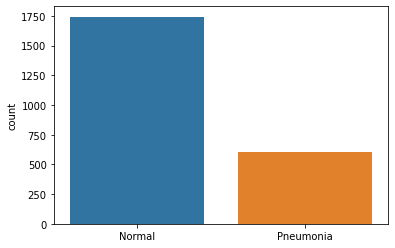

In [ ]:
import seaborn as sns

def show_histogram(labels):
  l=[]

  for label in labels:
    if (label==0):
      l.append("Pneumonia")
    else:
      l.append("Normal")

  #sns.set_style('whitegrid')
  sns.countplot(x=l)

#show distribution in training set
show_histogram(y_train)

Class distribution in validation dataset.

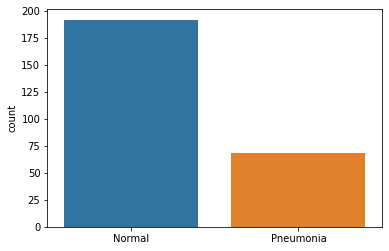

In [ ]:
show_histogram(y_val)


Class validation in testing dataset.

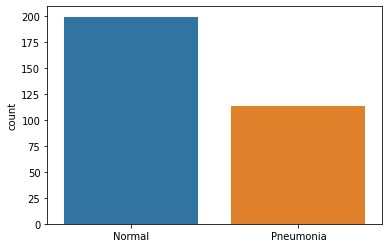

In [ ]:
show_histogram(y_test)


##Show Random Image in Dataset
To make sure that the images and labels are correctly loaded into memory, we will show a random image from a chosen dataset, with its label.

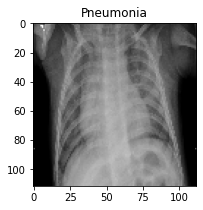

In [ ]:
import matplotlib.pyplot as plt

#function to randomly show an image in a dataset
#x_data: images
#y_data: labels
#
def show_random_image(x_data,y_data):
  plt.figure(figsize=(3,3))

  #get a random index within the range of the array
  #
  index=random.randint(0,len(x_data)-1)

  #get image
  #
  image=x_data[index]

  #plot image
  plt.imshow(image)

  #get label and show it
  if (y_data[index]==0):
    label="Normal"
  else:
    label="Pneumonia"
  plt.title(label)

#show a random image int the testing dataset
show_random_image(x_test,y_test)

##Pre-process Images

/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


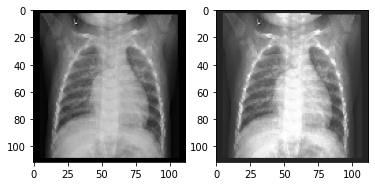

In [ ]:
#apply histogram equalisation

from skimage import exposure

#function to perform histogram equalisation on an image
#
def histogram_equalise(image):
  image_eq=exposure.equalize_hist(image)
  return image_eq


#take a random image from training set
#
index=random.randint(0,len(x_train)-1)

#original image
before=x_train[index]

#processed image
after=histogram_equalise(before)

#show both images
#
plt.figure(figsize=(6,6))
plt.subplot(1,2,1)
plt.imshow(before)
plt.subplot(1,2,2)
plt.imshow(after)


##Build CNN Model
This CNN model is similar to what we did in the previous lab. There are, however, some extra layers added:
1. Some [`BatchNormalization` layer](https://keras.io/api/layers/normalization_layers/batch_normalization/) are added. This is often used to speed up the training process and make it more stable.
You can read more about [batch normalization here](https://towardsdatascience.com/batch-normalization-in-3-levels-of-understanding-14c2da90a338).
1. The [`Dropout` layer](https://keras.io/api/layers/regularization_layers/dropout/) is used to prevent overfitting of the model.
1. As we are doing binary classification, we have 1 single output neuron, with the Sigmoid activation function.

In [ ]:
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras import layers
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Activation,Dropout,AveragePooling2D,

#defined earlier
#just as a reminder
#
#img_size=112

# Model setup
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size,3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(keras.layers.Conv2D(64, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size,3)))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(keras.layers.Conv2D(64, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size,3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(keras.layers.Conv2D(128, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size,3)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(keras.layers.Conv2D(256, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size,3)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2), strides = 2, padding = 'same'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units = 128, activation = 'relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(units = 1, activation = 'sigmoid'))

model.compile(
              optimizer = 'rmsprop', loss = 'binary_crossentropy', 
              metrics = ['accuracy']
              )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 56, 56, 64)       2

##Just Train the Model
You can just go ahead and train the model if you wish.
The following code is similar to what we used in the last lab.

**However, if you want to tweak your training, wait and see the following cells.**

In [ ]:
#train model
#
history=model.fit(x_train,y_train,epochs=n_epochs,batch_size=batch_size,
                  validation_data=(x_val,y_val))

##Image Data Generator


Keras has a [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) which can perform data augmentation.
We are just showing the code here.
Read the documentation for more details.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

datagen = ImageDataGenerator(
  featurewise_center=False, 
  samplewise_center=False, 
  featurewise_std_normalization=False, 
  samplewise_std_normalization=False, 
  zca_whitening=False, 
  rotation_range = 30, 
  zoom_range = 0.2, 
  width_shift_range = 0.1, 
  height_shift_range = 0.1, 
  horizontal_flip = True, 
  vertical_flip=False) 

datagen.fit(x_train)


##Cater for Class Imbalance
If you notice the distribution of classes in our dataset, there is a significant imbalance.
We can tell Keras to "pay more attention" to under-represented classes by passing a `class weight`.

The weight of each class is calculated by the following formulae:
<center>
$
weight_{0}=\frac{1}{neg} \times \frac{total}{2}
$

$
weight_{1}=\frac{1}{pos} \times \frac{total}{2}
$
</center>

See more information about **class weights** [here](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#calculate_class_weights)


In [ ]:
#count of negative and positive cases
#
neg=0
pos=0

for y in y_train:
  if y==0:
    neg=neg+1
  else:
    pos=pos+1

#total number of instances
total=neg+pos

#calculate weights for both classes
#
weight_for_0 = 1 /neg * (total/2.0)
weight_for_1 = 1/pos *(total/2.0)

#put weights into a dictionary
#
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Class weights: ',class_weight)

Class weights:  {0: 1.940495867768595, 1: 0.6735513482501434}


##Learning Rate

(https://keras.io/api/callbacks/reduce_lr_on_plateau/)

In [ ]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, verbose = 1, factor = 0.3, min_lr = 0.000001)



In [ ]:

history = model.fit(datagen.flow(x_train, y_train, batch_size = batch_size), 
                    epochs = n_epochs, validation_data = datagen.flow(x_val, y_val), 
                    callbacks = [learning_rate_reduction], class_weight = class_weight)



Epoch 1/25
147/147 [==============================] - 139s 922ms/step - loss: 0.6367 - accuracy: 0.8024 - val_loss: 12.3009 - val_accuracy: 0.7385 - lr: 0.0010
Epoch 2/25
147/147 [==============================] - 128s 870ms/step - loss: 0.4165 - accuracy: 0.8433 - val_loss: 7.0019 - val_accuracy: 0.7385 - lr: 0.0010
Epoch 3/25
147/147 [==============================] - ETA: 0s - loss: 0.3667 - accuracy: 0.8629
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
147/147 [==============================] - 151s 1s/step - loss: 0.3667 - accuracy: 0.8629 - val_loss: 12.0927 - val_accuracy: 0.7385 - lr: 0.0010
Epoch 4/25
147/147 [==============================] - 138s 941ms/step - loss: 0.2402 - accuracy: 0.9097 - val_loss: 0.6556 - val_accuracy: 0.6192 - lr: 3.0000e-04
Epoch 5/25
147/147 [==============================] - 132s 899ms/step - loss: 0.1903 - accuracy: 0.9229 - val_loss: 0.4139 - val_accuracy: 0.7962 - lr: 3.0000e-04
Epoch 6/25
147/147 [=================

##Show Training History

The following code to show the history is from the last lab.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


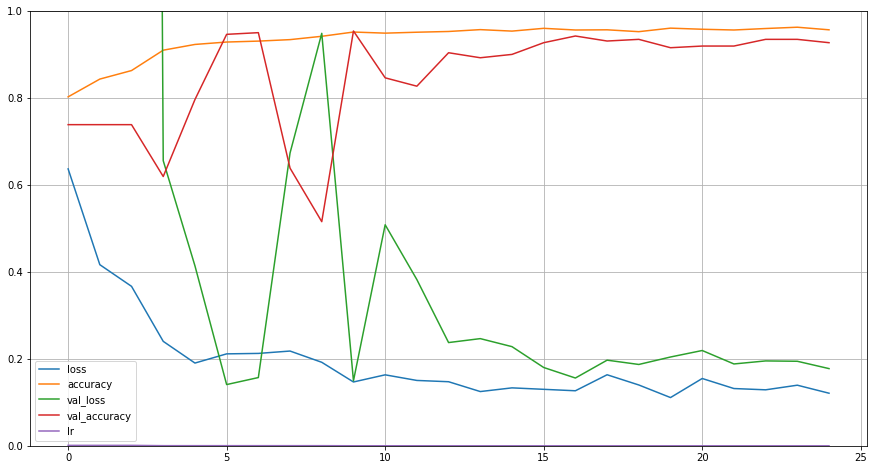

In [ ]:
import pandas as pd
import matplotlib.pyplot as pyplot

#show keys in the history
print(history.history.keys())

#plot graphs
pd.DataFrame(history.history).plot(figsize=(15,8))
pyplot.grid(True)
pyplot.gca().set_ylim(0,1)
pyplot.show()

##Show Training Loss & Validation Loss

<Axes: >

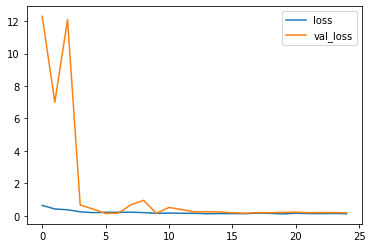

In [ ]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

##Show Training & Validation Accuracy

<Axes: >

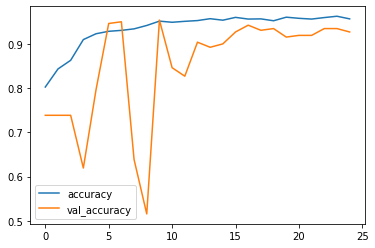

In [ ]:
losses[['accuracy','val_accuracy']].plot()

##Evaluate Using Testing Set

We can now use the testing dataset to evaluate our model.

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

10/10 [==============================] - 4s 391ms/step - loss: 0.2776 - accuracy: 0.9038
Loss of the model is -  0.2776120901107788
10/10 [==============================] - 3s 329ms/step - loss: 0.2776 - accuracy: 0.9038
Accuracy of the model is -  90.38461446762085 %


In [ ]:
from tensorflow.keras.models import load_model

predictions=model.predict(x_test) 
pred_labels= np.where(predictions>0.5, 1, 0)

10/10 [==============================] - 3s 281ms/step


##Precision, Recall, F1-score, and Support

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, pred_labels, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.84      0.91      0.87       113
   Normal (Class 1)       0.95      0.90      0.92       199

           accuracy                           0.90       312
          macro avg       0.89      0.91      0.90       312
       weighted avg       0.91      0.90      0.90       312



##Show Confusion Matrix

<Axes: >

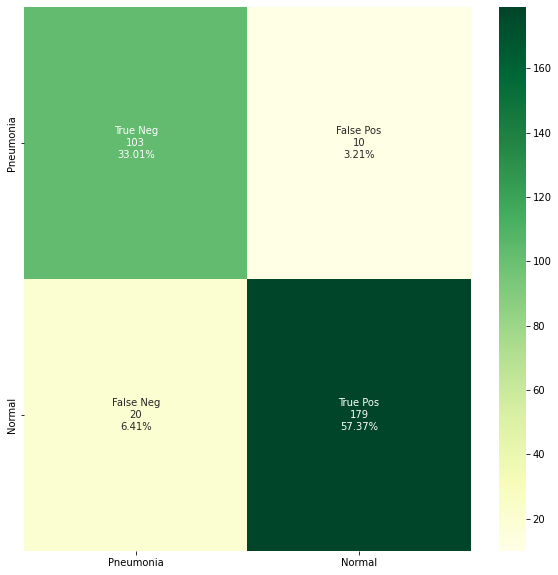

In [ ]:
cf_matrix = confusion_matrix(y_test, pred_labels)
plt.figure(figsize = (10,10))
classes = ['Pneumonia','Normal']
labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn" ,
            xticklabels = classes,yticklabels = classes
           )

#Transfer Learning

We can use a pre-trained model to perform classification.
In this example, we will use [ResNet152V2](https://keras.io/api/applications/resnet/#resnet152v2-function).
You can explore other pre-trained models available in Keras.
You can find more information [here](https://keras.io/guides/transfer_learning/).

Note:
1. We freeze all layers in the pre-trained model.
1. We add a customed input layer, and some dense layers for the output.

In [ ]:
from keras.applications.vgg16 import VGG16 #(if you want to use VG16)
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

tf.keras.backend.clear_session()

base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(img_size, img_size, 3),
    include_top=False)

# freeze the layers
base_model.trainable = False

In [ ]:
#function to get pre-trained model
#
def get_pretrained():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(img_size,img_size, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=[inputs], outputs=output)
    
    return model


##Use Pre-trained Model Directly

In [ ]:
model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005), metrics='binary_accuracy')

model_pretrained.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 4, 4, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

##Fit Data into Pre-trained Model

while the layers from the pre-trained model are frozen, we still need to train the dense layers.

In [ ]:
"""
history_tl = model_pretrained.fit(datagen.flow(x_train,y_train, batch_size = batch_size) ,
                    epochs = n_epochs , validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction],
                    steps_per_epoch = x_train.shape[0]/batch_size,
                    class_weight = class_weight
                   )
"""

history_tl=model.fit(x_train,y_train,epochs=n_epochs,batch_size=batch_size,
                  validation_data=(x_val,y_val))

##Showing Training History of Pre-trained Model

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


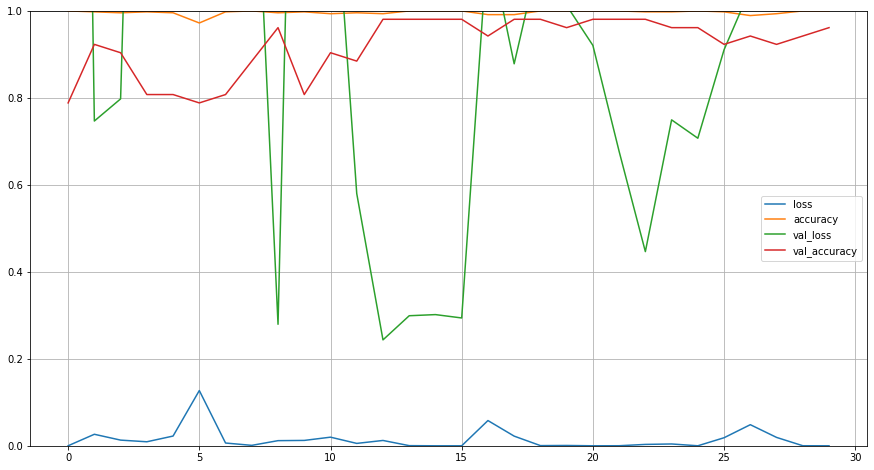

In [ ]:
import pandas as pd
import matplotlib.pyplot as pyplot

#show keys in the history
print(history_tl.history.keys())

#plot graphs
pd.DataFrame(history_tl.history).plot(figsize=(15,8))
pyplot.grid(True)
pyplot.gca().set_ylim(0,1)
pyplot.show()

##Evaluate Pre-trained Model

In [ ]:
print("Loss of the model is - " , model_pretrained.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model_pretrained.evaluate(x_test,y_test)[1]*100 , "%")


2/2 [==============================] - 14s 3s/step - loss: 1.5560 - binary_accuracy: 0.3065
Loss of the model is -  1.5560349225997925
2/2 [==============================] - 9s 6s/step - loss: 1.5560 - binary_accuracy: 0.3065
Accuracy of the model is -  30.645161867141724 %


##Fine-tuning Model

In the last example, we freeze all layers in the pre-trained ResNet model and only train the dense layers added by us.

To fine-tune the model, we can unfreeze some layers and retrain them specifically for this domain.
We usually keep the lower layers frozen as they capture generic patterns/features common in many domains.

In [ ]:
#first set whole model trainable
#
base_model.trainable = True

#then freeze all except the last 10 layers
#
for layer in base_model.layers[:-10]:
    layer.trainable = False

##Compile Fine-tune Model

In [ ]:
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = tf.keras.optimizers.Adam(learning_rate=0.000002), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 4, 4, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

##Fit Data Again
With the last 10 layers in the model made trainable, we will train it again.

In [ ]:
"""
history_ft = model_pretrained.fit(datagen.flow(x_train,y_train, batch_size = batch_size) ,
                    epochs = n_epochs , validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction],
                    steps_per_epoch = x_train.shape[0]/batch_size,
                    class_weight = class_weight
                   )
"""

history_ft=model_pretrained.fit(x_train,y_train,epochs=30,
                  validation_data=(x_val,y_val))

##Show Training History

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


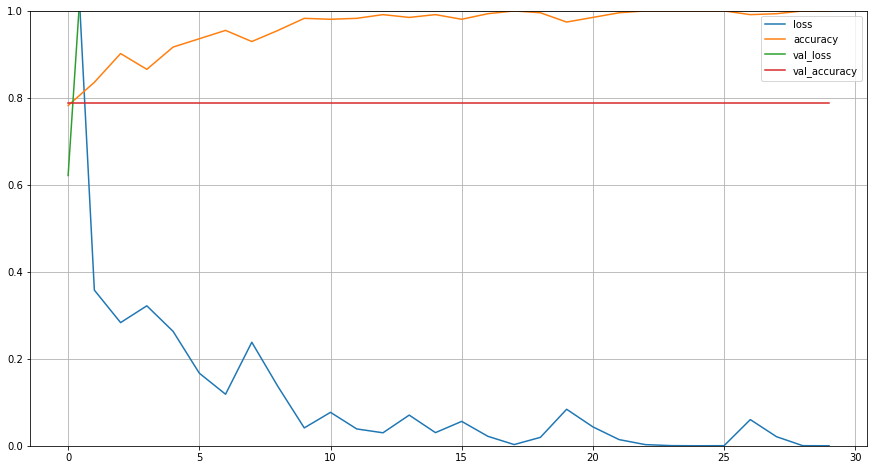

In [ ]:
import pandas as pd
import matplotlib.pyplot as pyplot

#show keys in the history
print(history.history.keys())

#plot graphs
pd.DataFrame(history.history).plot(figsize=(15,8))
pyplot.grid(True)
pyplot.gca().set_ylim(0,1)
pyplot.show()

##Evaluate Fine-tuned Model

In [ ]:
print("Loss of the model is - " , model_pretrained.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model_pretrained.evaluate(x_test,y_test)[1]*100 , "%")

2/2 [==============================] - 9s 5s/step - loss: 0.5130 - binary_accuracy: 0.7258
Loss of the model is -  0.5130043029785156
2/2 [==============================] - 12s 9s/step - loss: 0.5130 - binary_accuracy: 0.7258
Accuracy of the model is -  72.5806474685669 %


##Confusion Matrix of Fine-tuned Model

<Axes: >

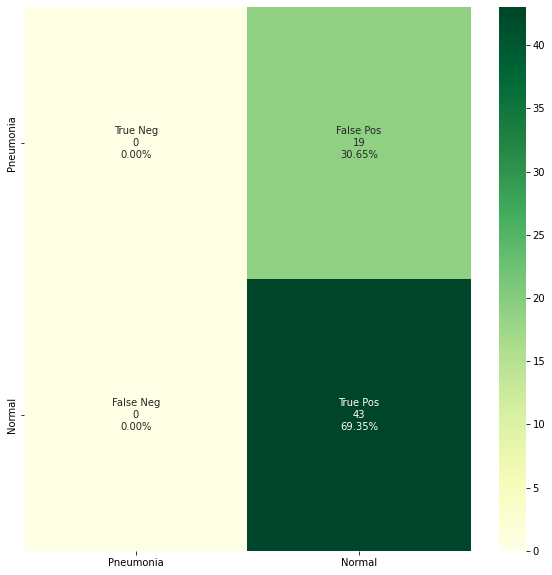

In [ ]:
cf_matrix = confusion_matrix(y_test, pred_labels)
plt.figure(figsize = (10,10))

labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn",
           xticklabels = classes,yticklabels = classes)

##Clean Up
If you need to, the following code terminates the kernel and free memory before running new experiments.

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)
